<a href="https://colab.research.google.com/github/les67/PyTorch/blob/main/pytorch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quickly Learning Pytorch Basics
  - Following: [https://github.com/yunjey/pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial)

## 1. Linear Regression Model 

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

- The weird formatting for x_train and y_train is the only way the line `outputs = model(inputs)` works during training. If you take out the unnecessary dimension it complains with `RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x15 and 1x1)`. Weird 

In [13]:
# Hyper-parameters
input_size = 1
output_size = 1
num_epochs = 60
learning_rate = 0.001

# Toy dataset
x_train = np.array([[3.3], [4.4], [5.5], [6.71], [6.93], [4.168], 
                    [9.779], [6.182], [7.59], [2.167], [7.042], 
                    [10.791], [5.313], [7.997], [3.1]], dtype=np.float32)

y_train = np.array([[1.7], [2.76], [2.09], [3.19], [1.694], [1.573], 
                    [3.366], [2.596], [2.53], [1.221], [2.827], 
                    [3.465], [1.65], [2.904], [1.3]], dtype=np.float32)

- Single neural layer to approximate linear regression
  - One input (x) and one output (y)
- Stochastic gradient descent with fixed learning rate

In [14]:
# Linear regression model
model = nn.Linear(input_size, output_size) # A single nueral layer

# Loss and optimizer
criterion = nn.MSELoss() # Mean-squared Error
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # Stochastic gradient descent 

- The following seems to be the basic pattern to train in pytorch
- `loss.backward()` computes dloss/dx for every parameter x which has requires_grad=True
- These are accumulated into x.grad for every parameter x: x.grad += dloss/dx
- `optimizer.step` updates the value of x using the gradient x.grad
  - Ex. the SGD optimizer performs: x += -lr * x.grad
- `optimizer.zero_grad()` clears x.grad for every parameter x in the optimizer. It’s important to call this before `loss.backward()`, otherwise you’ll accumulate the gradients from multiple passes
- If you have multiple losses (loss1, loss2) you can sum them and then call backwards once:
  - `loss3 = loss1 + loss2; loss3.backward()`

In [15]:
# Train the model
for epoch in range(num_epochs):
    # Convert numpy arrays to torch tensors
    inputs = torch.from_numpy(x_train)
    targets = torch.from_numpy(y_train)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


Epoch [5/60], Loss: 6.5052
Epoch [10/60], Loss: 2.7465
Epoch [15/60], Loss: 1.2238
Epoch [20/60], Loss: 0.6069
Epoch [25/60], Loss: 0.3570
Epoch [30/60], Loss: 0.2557
Epoch [35/60], Loss: 0.2146
Epoch [40/60], Loss: 0.1980
Epoch [45/60], Loss: 0.1912
Epoch [50/60], Loss: 0.1884
Epoch [55/60], Loss: 0.1873
Epoch [60/60], Loss: 0.1868


In [17]:
inputs

tensor([[ 3.3000],
        [ 4.4000],
        [ 5.5000],
        [ 6.7100],
        [ 6.9300],
        [ 4.1680],
        [ 9.7790],
        [ 6.1820],
        [ 7.5900],
        [ 2.1670],
        [ 7.0420],
        [10.7910],
        [ 5.3130],
        [ 7.9970],
        [ 3.1000]])

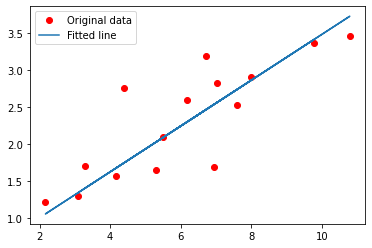

In [16]:
# Plot the graph
predicted = model(torch.from_numpy(x_train)).detach().numpy()
plt.plot(x_train, y_train, 'ro', label='Original data')
plt.plot(x_train, predicted, label='Fitted line')
plt.legend()
plt.show()

## 2. Logistic Regression Model

In [18]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

- We use a batch size this time yay!
- Dataset is the MNIST handwritten images which we want to classify into 10 possible digits (1,2,3,...,10)

In [33]:
# Hyper-parameters 
input_size = 28 * 28    # 784
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

- Load train and testing data
- Standard scale the data

In [34]:
# MNIST dataset (images and labels)
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.1307,), (0.3081,))]), # standard scaling with mean and std of MNIST set
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.1307,), (0.3081,))]),
                                          )

# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [35]:
# Logistic regression model
model = nn.Linear(input_size, num_classes)

- Use cross-entropy loss since we're dealing with multiclass

In [36]:
# Loss and optimizer
# nn.CrossEntropyLoss() computes softmax internally
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

- Iterate through specified epochs
- For every epoch iterate through batches

In [37]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Reshape images to (batch_size, input_size)
        images = images.reshape(-1, input_size)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 1.5786
Epoch [1/5], Step [200/600], Loss: 1.0839
Epoch [1/5], Step [300/600], Loss: 0.8251
Epoch [1/5], Step [400/600], Loss: 0.8874
Epoch [1/5], Step [500/600], Loss: 0.7727
Epoch [1/5], Step [600/600], Loss: 0.6870
Epoch [2/5], Step [100/600], Loss: 0.6643
Epoch [2/5], Step [200/600], Loss: 0.6402
Epoch [2/5], Step [300/600], Loss: 0.5758
Epoch [2/5], Step [400/600], Loss: 0.5755
Epoch [2/5], Step [500/600], Loss: 0.6582
Epoch [2/5], Step [600/600], Loss: 0.4025
Epoch [3/5], Step [100/600], Loss: 0.5142
Epoch [3/5], Step [200/600], Loss: 0.4679
Epoch [3/5], Step [300/600], Loss: 0.5751
Epoch [3/5], Step [400/600], Loss: 0.5129
Epoch [3/5], Step [500/600], Loss: 0.5084
Epoch [3/5], Step [600/600], Loss: 0.6113
Epoch [4/5], Step [100/600], Loss: 0.4673
Epoch [4/5], Step [200/600], Loss: 0.4989
Epoch [4/5], Step [300/600], Loss: 0.3799
Epoch [4/5], Step [400/600], Loss: 0.3718
Epoch [4/5], Step [500/600], Loss: 0.3673
Epoch [4/5], Step [600/600], Loss:

In [38]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, input_size)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the model on the 10000 test images: 89.12000274658203 %


- Note: Without standard scaling the accuracy was ~13%, increased to ~89% after standard scaling
## 3. Feed-Forward Neural Network

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 784 # this is 28*28 since each image is 28 by 28 pixels
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

In [5]:
# MNIST dataset (images and labels)
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.1307,), (0.3081,))]), # standard scaling with mean and std of MNIST set
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.1307,), (0.3081,))]),
                                          )

# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

- Fully-connected NN with one layer:

In [6]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [7]:
# Model
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [8]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): 
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 0.3086
Epoch [1/5], Step [200/600], Loss: 0.2133
Epoch [1/5], Step [300/600], Loss: 0.0751
Epoch [1/5], Step [400/600], Loss: 0.1887
Epoch [1/5], Step [500/600], Loss: 0.1802
Epoch [1/5], Step [600/600], Loss: 0.1266
Epoch [2/5], Step [100/600], Loss: 0.2049
Epoch [2/5], Step [200/600], Loss: 0.0505
Epoch [2/5], Step [300/600], Loss: 0.0245
Epoch [2/5], Step [400/600], Loss: 0.0164
Epoch [2/5], Step [500/600], Loss: 0.0771
Epoch [2/5], Step [600/600], Loss: 0.1220
Epoch [3/5], Step [100/600], Loss: 0.0173
Epoch [3/5], Step [200/600], Loss: 0.0471
Epoch [3/5], Step [300/600], Loss: 0.0681
Epoch [3/5], Step [400/600], Loss: 0.0108
Epoch [3/5], Step [500/600], Loss: 0.0410
Epoch [3/5], Step [600/600], Loss: 0.0273
Epoch [4/5], Step [100/600], Loss: 0.1101
Epoch [4/5], Step [200/600], Loss: 0.0219
Epoch [4/5], Step [300/600], Loss: 0.0174
Epoch [4/5], Step [400/600], Loss: 0.0241
Epoch [4/5], Step [500/600], Loss: 0.0728
Epoch [4/5], Step [600/600], Loss:

In [9]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 97.67 %


- Visualize

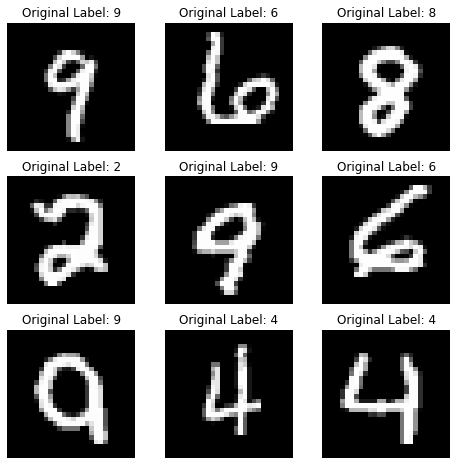

In [55]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
indices = []
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
    indices.append(sample_idx)
    img, label = test_dataset[sample_idx]
    #print(img.shape)
    figure.add_subplot(rows, cols, i)
    plt.title('Original Label: '+str(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

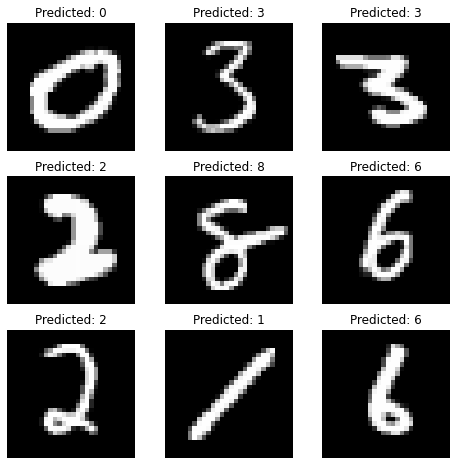

In [53]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1,len(indices)+1):
    img, og_label = test_dataset[indices[i-1]]
    img = img.reshape(-1, 28*28).to(device)
    outputs = model(img)
    # print(outputs.data) # something like tensor([[-12.5591,  -8.9011,  -1.5942,   0.3909, -16.9197, -14.8808, -21.0030, 15.4967,  -1.7179,   0.0993]], device='cuda:0')
    _, predicted_label = torch.max(outputs.data, 1) # returns max along dimension 1
    predicted_label = predicted_label.to(device)
    figure.add_subplot(rows, cols, i)
    predicted_label = predicted_label.cpu().numpy()
    #print(predicted_label)
    plt.title('Predicted: '+str(predicted_label[0]))
    plt.axis("off")
    plt.imshow(img.cpu().reshape((28,28)).squeeze(), cmap="gray")
plt.show()